<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_Arch_to_LDS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture to LDS Data Experiments v1
LDS = "Laser Distance Sensor"

In [87]:
# Setup common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from IPython.display import Image
from PIL import Image
import requests
import math

In [27]:
# Load single black'n'white image as source data from github
#arch = Image.open()
url = "https://github.com/malcolmlett/robovac/blob/main/data/experimental-architecture1.png?raw=true"
arch = Image.open(requests.get(url, stream=True).raw)
arch = np.array(arch, dtype=np.bool_)
arch.shape

(84, 94)

In [73]:
# Pick a coordinate as our location (x,y)
loc = (60, 25)

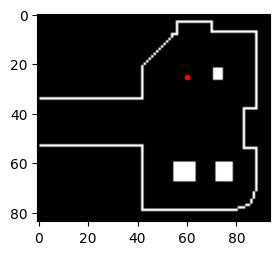

In [75]:
# Show what we've got, and overlay a coloured dot on the coordinate of loc
plt.figure(figsize=(3, 3))
plt.imshow(arch, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.show()


## Generate LDS Data
Algorithm:
* Initialise 360 traces, with:
  * initial position at centre
  * step_x/step_y calculated according to their angle and the distance increment
  * a value indicating how much of the trace has been consumed (in range 0.0 to 1.0)
  * a value indicating its current distance (initially NaN)


In next revision I want to assume that the trace has a fixed width, that acts normal to its movement direction, and that it gets consumed if it hits anything along that width. Also, it needs to consider the whole _area_ between where it started from in the previous step to where it's ended up now, times its width.

In [135]:
# Function to generate LDS Data from an architectural image.
# Input:
#   - 2D array of bool
#   - centre - (x, y) position at centre of LDS data
#   - angle  - angle of orientation (radians), to any resolution
# Output:
#   - 365x1 array of double, for each 365 degree angle, starting from in front and going clockwise, holding simulated LDS distance data (or NaN for no hit),
# Config:
#   - max distance
def lds_sample(arch, centre, angle):
  dist_increment = 1
  max_distance = 100.0

  # initialise
  angles = np.linspace(0, np.pi*2, num=360, endpoint=False) + angle
  ranges = np.full(360, max_distance*2)  # initially to a too-large value and truncate later
  #consumption = np.full(360, 0.0)
  points = np.tile(np.array(centre, dtype=np.float32), (360,1))  # current location of trace
  steps_x = np.cos(angles).reshape(-1,1)
  steps_y = np.sin(angles).reshape(-1,1)
  steps = np.hstack((steps_x, steps_y)) * dist_increment
  print(points.shape)

  print(f"Initialised:")
  print(f" - angles:      {angles.shape}")
  print(f" - ranges:      {angles.shape}")
  #print(f" - consumption: {consumption.shape}")
  print(f" - points:      {points.shape}")
  print(f" - steps:       {steps.shape}")

  dist = 0.0
  for i in range(math.ceil(max_distance / dist_increment)):
    # increment all points
    points += steps
    dist = i * dist_increment
    new_ranges = np.copy(ranges)

    # check for hits in any of the surrounding 4 pixels that each trace point might overlap with
    hit_x = np.floor(points[:,0]).astype(np.int32)
    hit_y = np.floor(points[:,1]).astype(np.int32)
    hit_x = np.maximum(0, np.minimum(arch.shape[1]-1, hit_x))
    hit_y = np.maximum(0, np.minimum(arch.shape[0]-1, hit_y))
    lookups = np.hstack((hit_y.reshape(-1,1), hit_x.reshape(-1,1)))
    #print(f"lookups: {lookups.shape}")
    hits = arch[tuple(np.transpose(lookups))]
    new_ranges[hits] = dist
    ranges = np.minimum(ranges, new_ranges)
    #print(f"{dist}: {np.sum(ranges < max_distance*2)}")

  # prune and return
  ranges[ranges > max_distance] = np.nan
  return ranges

o = lds_sample(arch, loc, 0.0)

(360, 2)
Initialised:
 - angles:      (360,)
 - ranges:      (360,)
 - points:      (360, 2)
 - steps:       (360, 2)


In [136]:
# Returns:
#   - list of valid (omits nans)
def lds_to_2d(ranges, centre, angle):
  angles = np.linspace(0, np.pi*2, num=360, endpoint=False) + angle

  steps_x = np.cos(angles).reshape(-1,1)
  steps_y = np.sin(angles).reshape(-1,1)
  steps = np.hstack((steps_x, steps_y))
  points = steps * ranges.reshape(-1,1) + centre
  return points

o = lds_to_2d(lds_sample(arch, loc, 0.0), loc, 0.0)

(360, 2)
Initialised:
 - angles:      (360,)
 - ranges:      (360,)
 - points:      (360, 2)
 - steps:       (360, 2)


(360, 2)
Initialised:
 - angles:      (360,)
 - ranges:      (360,)
 - points:      (360, 2)
 - steps:       (360, 2)


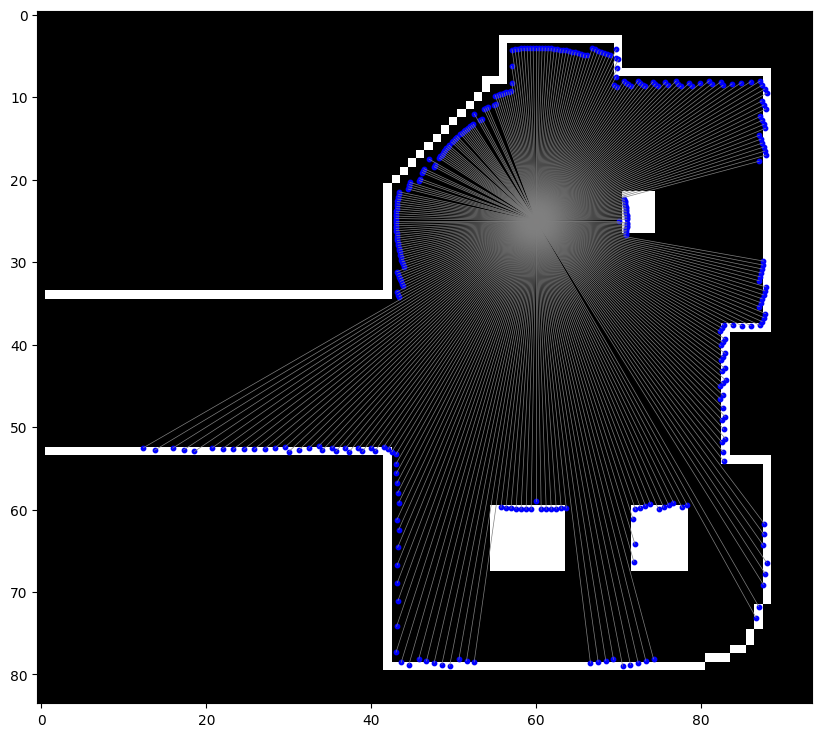

In [142]:
# try it out
points = lds_to_2d(lds_sample(arch, loc, 0.0), loc, 0.0)
plt.figure(figsize=(10, 10))
plt.imshow(arch, cmap='gray')
for x, y in points:
  plt.plot([loc[0], x], [loc[1], y], color='grey', linewidth=0.5)
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.scatter(points[:,0], points[:,1], c='b', s=10)
plt.show()